# PPO Implementation

- 고려대학교 석사과정 최선묵

In [2]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.7 MB/s eta 0:00:00


In [3]:
from datetime import datetime
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense

In [4]:
class Proximal_Policy_Optimization_Actor():
    def __init__(self, input_shape=(4,), num_actions=2, epsilon=0.2, entropy_coef=0.1, pretrained=''):

        self.agent = self.nn_model(input_size=input_shape, action_dim=num_actions)

        if pretrained:
            self.load_model(pretrained)

        self.optimizer=tf.keras.optimizers.Adam()
        self.epsilon=epsilon
        self.entropy_coef=entropy_coef

    def nn_model(self, input_size, action_dim):
        input_layer = Input(shape=input_size)
        x = Dense(128, activation='relu', kernel_initializer='he_uniform')(input_layer)
        x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
        x = Dense(16, activation='relu', kernel_initializer='he_uniform')(x)
        output_layer = Dense(action_dim, activation='linear')(x)

        model = Model(input_layer, outputs = output_layer)
        return model

    def sample_action(self, state):
        state = state.reshape(1,-1)
        policy_logits = self.agent.predict_on_batch(state)

        return int(tf.random.categorical(policy_logits, 1)), tf.nn.softmax(policy_logits)

    def compute_loss(self, old_policy, new_policy, gaes):
        ratio = new_policy / old_policy
        clipped_ratio = tf.clip_by_value(ratio, 1-self.epsilon, 1+self.epsilon)
        surrogate = tf.minimum(ratio*gaes, clipped_ratio*gaes)
        return -tf.reduce_mean(surrogate)

    def learn(self, old_policy_arr, state_arr, action_arr, gaes):
        with tf.GradientTape() as tape:
            new_policy_logits = self.agent(state_arr, training=True)                            # (epi_len, 2)
            new_policy = tf.reduce_sum(tf.nn.softmax(new_policy_logits)*action_arr, axis=1)     # (epi_len, )
            old_policy = tf.reduce_sum(old_policy_arr*action_arr, axis=1)                       # (epi_len, )

            clip_loss = self.compute_loss(old_policy, new_policy, gaes)
            entropy = -tf.reduce_sum(tf.nn.softmax(new_policy_logits)*tf.nn.log_softmax(new_policy_logits), axis=1)
            loss = clip_loss - self.entropy_coef*entropy
        grads = tape.gradient(loss, self.agent.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.agent.trainable_variables))
        return loss

    def save_model(self, mdir):
        self.agent.save_weights(mdir)

    def load_model(self, mdir):
        self.agent.load_weights(mdir)

class Proximal_Policy_Optimization_Critic():
    def __init__(self, input_shape=(4,), target='MC', pretrained=''):
        self.agent = self.nn_model(input_size=input_shape)
        if pretrained:
            self.load_model(pretrained)

        self.target = target
        self.optimizer = tf.keras.optimizers.Adam()

    def nn_model(self, input_size):
        input_layer = Input(shape=input_size)
        x = Dense(128, activation='relu', kernel_initializer='he_uniform')(input_layer)
        x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
        x = Dense(16, activation='relu', kernel_initializer='he_uniform')(x)
        output_layer = Dense(1, activation='linear')(x)

        model = Model(input_layer, outputs = output_layer)
        return model

    def compute_return(self, reward_arr, gamma):
        discounted_return = 0
        return_arr = np.zeros(reward_arr.shape)

        for i in range(reward_arr.shape[0]-1,-1,-1):
            discounted_return = gamma * discounted_return + reward_arr[i]
            return_arr[i] = discounted_return

        return return_arr

    def learn(self, state_arr, next_state_arr, reward_arr, done_arr, gamma):

        if self.target == 'TD':
            with tf.GradientTape() as tape:
                cur_values_arr  = self.agent(state_arr, training=True)
                next_values_arr = tf.stop_gradient(self.agent(next_state_arr))
                td_arr = reward_arr + gamma*next_values_arr*(1-done_arr) - cur_values_arr
                loss = tf.reduce_mean(td_arr**2)
            grads = tape.gradient(loss, self.agent.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.agent.trainable_variables))

        elif self.target == 'MC':
            with tf.GradientTape() as tape:
                cur_values_arr  = self.agent(state_arr, training=True)
                return_arr = self.compute_return(reward_arr, gamma)
                loss = tf.reduce_mean((return_arr-cur_values_arr)**2)
            grads = tape.gradient(loss, self.agent.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.agent.trainable_variables))

        else:
            raise ValueError("Critic Target should be either 'MC' or 'TD'.")
        return loss

    def save_model(self, mdir):
        self.agent.save_weights(mdir)

    def load_model(self, mdir):
        self.agent.load_weights(mdir)

In [5]:
class Play_Env_PPO():
    def __init__(self, env, clip=0.2, e=0.1, g=0.99, lam=0.95, critic_target='MC', pre_ppo_actor='', pre_ppo_critic=''):

        self.env = env
        self.input_shape = env.observation_space.shape
        self.action_num = env.action_space.n

        self.actor = Proximal_Policy_Optimization_Actor(input_shape=self.input_shape, num_actions=self.action_num, epsilon=clip, entropy_coef=e, pretrained=pre_ppo_actor)
        self.critic = Proximal_Policy_Optimization_Critic(input_shape=self.input_shape, target=critic_target, pretrained=pre_ppo_critic)

        self.gamma = g
        self.gae_lambda = lam

    def rollout(self):
        one_hot_encoding = np.eye(self.action_num, dtype=np.float32)

        state_list, action_list, reward_list, next_state_list, old_policy_list, done_list  = [], [], [], [], [], []

        done, episode_reward = 0, 0
        state, _ = self.env.reset()
        action, action_prob = self.actor.sample_action(state)

        while not done:
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = int(terminated or truncated)

            state_list.append(state)
            action_list.append(one_hot_encoding[action])
            reward_list.append(reward)

            episode_reward += reward

            next_state_list.append(next_state)
            old_policy_list.append(action_prob)

            if done:
                done = 1
            done_list.append(done)

            if not done:
                next_action, next_action_prob = self.actor.sample_action(next_state)
                action = next_action
                state = next_state
                action_prob = next_action_prob

            state_arr = np.array(state_list)
            action_arr = np.array(action_list)
            reward_arr = np.array(reward_list).reshape(-1,1)
            next_state_arr = np.array(next_state_list)
            old_policy_arr = np.array(old_policy_list).reshape(-1,self.action_num)
            done_arr = np.array(done_list).reshape(-1,1)

        return state_arr, action_arr, reward_arr, next_state_arr, old_policy_arr, done_arr

    def compute_gae(self, td_arr):
        gae_cumulative = 0
        gae_arr = np.zeros(td_arr.shape)

        for i in range(td_arr.shape[0]-1, -1, -1):
            gae_cumulative = self.gamma * self.gae_lambda * gae_cumulative + td_arr[i]
            gae_arr[i] = gae_cumulative

        return gae_arr

    def update(self, state_arr, action_arr, reward_arr, next_state_arr, old_policy_arr, done_arr):
        cur_values_arr  = self.critic.agent.predict_on_batch(state_arr)                     # (epi_len, 1)
        next_values_arr = self.critic.agent.predict_on_batch(next_state_arr)                # (epi_len, 1)

        td_arr = reward_arr + self.gamma*next_values_arr*(1-done_arr) - cur_values_arr      # (epi_len, 1)
        gae_arr = self.compute_gae(td_arr)

        self.actor.learn(old_policy_arr, state_arr, action_arr, gae_arr)
        self.critic.learn(state_arr, next_state_arr, reward_arr, done_arr, self.gamma)

        return

    def train_agent(self, episode_number, iteration=2, print_log=True):

        episode_len_list = []

        for episode in range(episode_number):
            state_arr, action_arr, reward_arr, next_state_arr, old_policy_arr, done_arr = self.rollout()

            for _ in range(iteration):
                self.update(state_arr, action_arr, reward_arr, next_state_arr, old_policy_arr, done_arr)

            episode_len_list.append(reward_arr.shape[0])

            if print_log:
                print(f"Episode#:{episode} episode length:{episode_len_list[-1]:.2f}")

        return episode_len_list

    def train_agent_log(self, episode_number, iteration=2, odir=''):

        episode_len = open(os.path.join(odir, self.class_name, self.model_name+'_epi_len_log.txt'),'a+')

        episode_len_list = []

        for episode in range(episode_number):
            state_arr, action_arr, reward_arr, next_state_arr, old_policy_arr, done_arr = self.rollout()

            for _ in range(iteration):
                self.update(state_arr, action_arr, reward_arr, next_state_arr, old_policy_arr, done_arr)

            episode_len_list.append(reward_arr.shape[0])
            episode_len.write(str(reward_arr.shape[0]) + ' ')
            episode_len.flush()

        episode_len.close()

        return episode_len_list

    def save_agent(self, odir=''):
        actor_name  = 'PPO_actor_'+self.critic.target
        critic_name = 'PPO_critic_'+self.critic.target

        self.actor.save_model(os.path.join(odir, actor_name))
        self.critic.save_model(os.path.join(odir, critic_name))

## TD target Performance

In [6]:
episode_num = 500

ppo_actor_model = ''
ppo_critic_model = ''

clip_lim  = 0.2
entropy_coef = 0.1
gamma = 0.99
gae_lambda = 0.95
critic_target = 'TD'

update_iteration = 2

repeat = 3
episode_len_total_arr1 = np.zeros((repeat, episode_num))

for i in range(repeat):
    game = Play_Env_PPO(env=gym.make("CartPole-v1"), clip=clip_lim, e=entropy_coef, g=gamma, lam=gae_lambda, critic_target=critic_target, pre_ppo_actor=ppo_actor_model, pre_ppo_critic=ppo_critic_model)
    episode_len_list = game.train_agent(episode_num, iteration=update_iteration, print_log=False)
    episode_len_total_arr1[i] = np.array(episode_len_list)


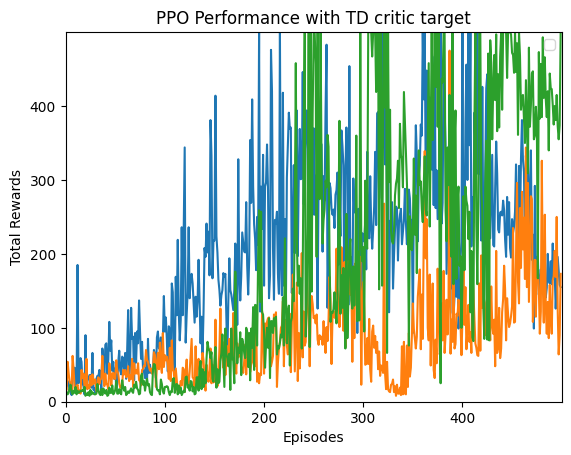

In [7]:
plt.plot(np.arange(episode_num), episode_len_total_arr1[0])
plt.plot(np.arange(episode_num), episode_len_total_arr1[1])
plt.plot(np.arange(episode_num), episode_len_total_arr1[2])

plt.axis([0,episode_num, 0,500])
plt.xticks(np.arange(0,episode_num,100))
plt.yticks(np.arange(0,500,100))
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('PPO Performance with TD critic target')
plt.savefig('PPO_Performance_TD_target.png', dpi=300)
plt.show()

## MC Target Performance

In [8]:
episode_num = 500

ppo_actor_model = ''
ppo_critic_model = ''

clip_lim  = 0.2
entropy_coef = 0.1
gamma = 0.99
gae_lambda = 0.95
critic_target = 'MC'

update_iteration = 2

repeat = 3
episode_len_total_arr2 = np.zeros((repeat, episode_num))

for i in range(repeat):
    game = Play_Env_PPO(env=gym.make("CartPole-v1"), clip=clip_lim, e=entropy_coef, g=gamma, lam=gae_lambda, critic_target=critic_target, pre_ppo_actor=ppo_actor_model, pre_ppo_critic=ppo_critic_model)
    episode_len_list = game.train_agent(episode_num, iteration=update_iteration, print_log=False)
    episode_len_total_arr2[i] = np.array(episode_len_list)


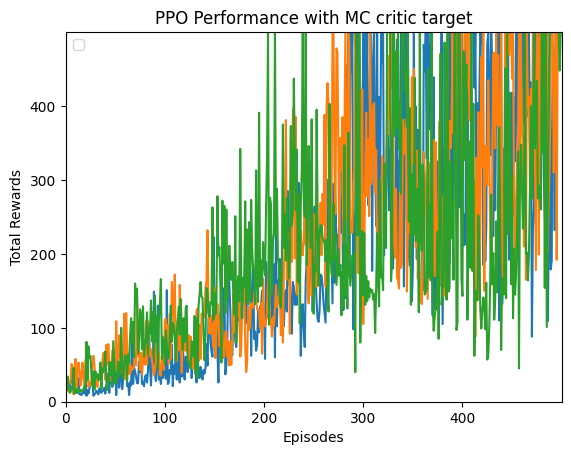

In [9]:
plt.plot(np.arange(episode_num), episode_len_total_arr2[0])
plt.plot(np.arange(episode_num), episode_len_total_arr2[1])
plt.plot(np.arange(episode_num), episode_len_total_arr2[2])

plt.axis([0,episode_num, 0, 500])
plt.xticks(np.arange(0,episode_num,100))
plt.yticks(np.arange(0,500,100))
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('PPO Performance with MC critic target')
plt.savefig('PPO_Performance_MC_target.png', dpi=300)
plt.show()